## Install some libraries

In [1]:
!pip install tensorflow pandas scikit-learn yfinance


In [26]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

import yfinance as yf

pd.set_option('display.max_columns',None)

## User defined functions

In [3]:
def call_rmsle(y_true, y_pred):
    # Ensure predictions and true values are positive by adding 1
    y_true = tf.math.maximum(y_true, 0)
    y_pred = tf.math.maximum(y_pred, 0)

    # Compute the logarithm of the true and predicted values
    log_true = tf.math.log1p(y_true)
    log_pred = tf.math.log1p(y_pred)

    # Compute the squared difference
    squared_diff = tf.math.square(log_true - log_pred)

    # Compute the mean of the squared differences
    mean_squared_diff = tf.math.reduce_mean(squared_diff)

    # Return the square root of the mean squared differences
    return tf.math.sqrt(mean_squared_diff)

def remove_leading_zeros(df):
    # Find the index of the first non-zero sales value
    first_non_zero_index = df['sales'].ne(0).idxmax()

    # Filter the DataFrame to remove leading zeros
    return df.loc[first_non_zero_index:]

## Load the data

In [64]:
#df_train_all    = pd.read_csv('data/SPX.csv')

start_date = "2021-01-03"
end_date   = "2024-11-01"

data = yf.download("^NSEI", start=start_date, end=end_date)
data.columns = data.columns.get_level_values(0) # from multi index to single index

data = data.reset_index()

print(data.head())



[*********************100%***********************]  1 of 1 completed

Price                      Date     Adj Close         Close          High  \
0     2021-01-04 00:00:00+00:00  14132.900391  14132.900391  14147.950195   
1     2021-01-05 00:00:00+00:00  14199.500000  14199.500000  14215.599609   
2     2021-01-06 00:00:00+00:00  14146.250000  14146.250000  14244.150391   
3     2021-01-07 00:00:00+00:00  14137.349609  14137.349609  14256.250000   
4     2021-01-08 00:00:00+00:00  14347.250000  14347.250000  14367.299805   

Price           Low          Open  Volume  
0      13953.750000  14104.349609  495000  
1      14048.150391  14075.150391  492500  
2      14039.900391  14240.950195  632300  
3      14123.099609  14253.750000  559200  
4      14221.650391  14258.400391  613500  


In [65]:
data.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [66]:

data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
data['Date'] = pd.to_datetime(data['Date']).dt.date
#data.set_index('Date', inplace=True)

df_train_all = data.copy()

df_train_all.head()


Price,Date,Adj Close,Close,High,Low,Open,Volume
0,2021-01-04,14132.900391,14132.900391,14147.950195,13953.750000,14104.349609,495000
1,2021-01-05,14199.500000,14199.500000,14215.599609,14048.150391,14075.150391,492500
2,2021-01-06,14146.250000,14146.250000,14244.150391,14039.900391,14240.950195,632300
3,2021-01-07,14137.349609,14137.349609,14256.250000,14123.099609,14253.750000,559200
4,2021-01-08,14347.250000,14347.250000,14367.299805,14221.650391,14258.400391,613500


## Feature engineering

In [67]:
df_train_all['10DMA'] =  df_train_all['Adj Close'].rolling(window=10).mean()
df_train_all['30DMA'] =  df_train_all['Adj Close'].rolling(window=30).mean()
df_train_all['100DMA'] =  df_train_all['Adj Close'].rolling(window=100).mean()

df_train_all.dropna(subset=['100DMA'], inplace=True)

In [68]:
import calendar
from datetime import datetime, timedelta
def is_last_thursday(date):
    year = date.year
    month = date.month
    
    last_day = calendar.monthrange(year, month)[1]
    last_date = datetime(year, month, last_day)
    last_day_weekday = last_date.weekday()
    days_since_last_thursday = (last_day_weekday - calendar.THURSDAY) % 7
    last_thursday_date = last_date - timedelta(days=days_since_last_thursday)
    
    return 1 if date.date() == last_thursday_date.date() else 0




In [69]:
df_train_all.columns


Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', '10DMA',
       '30DMA', '100DMA'],
      dtype='object', name='Price')

In [70]:
df_train_all['Date'] = pd.to_datetime(df_train_all['Date'])

df_train_all['day'] = df_train_all['Date'].dt.day
df_train_all['month'] = df_train_all['Date'].dt.month
df_train_all['year'] = df_train_all['Date'].dt.year

df_train_all['opt_exp'] = df_train_all['Date'].apply(is_last_thursday)
df_train_all['year'] = df_train_all['year'] - df_train_all['year'].min()


In [71]:


# Convert month and day to cyclical features
#df_train_all['month_sin'] = np.sin(2 * np.pi * df_train_all['month'] / 12)
#df_train_all['month_cos'] = np.cos(2 * np.pi * df_train_all['month'] / 12)
#df_train_all['day_sin'] = np.sin(2 * np.pi * df_train_all['day'] / 31)
#df_train_all['day_cos'] = np.cos(2 * np.pi * df_train_all['day'] / 31)



In [72]:
df_train_all['next_close'] = df_train_all['Close'].shift(-1)
df_train_all['pct_change'] = df_train_all['next_close'] - df_train_all['Close']
df_train_all.dropna(subset=['pct_change'], inplace=True)

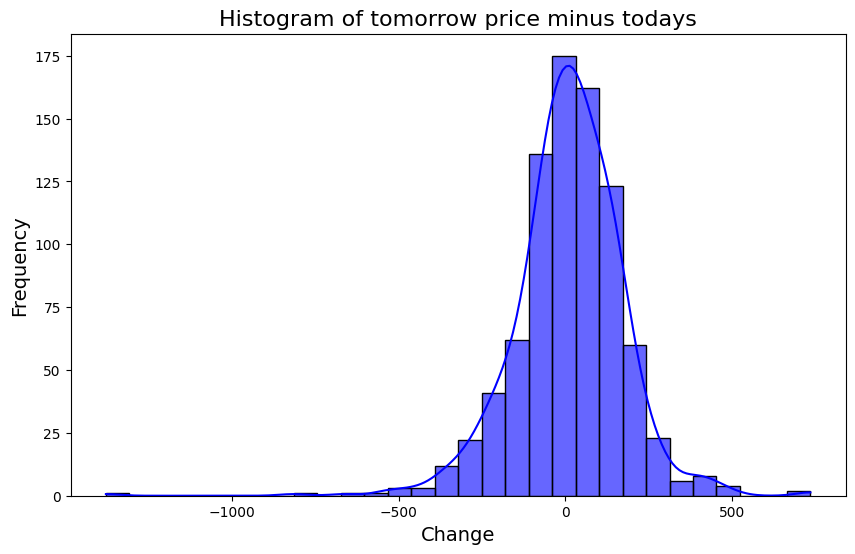

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_train_all['pct_change'].dropna(), bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of tomorrow price minus todays', fontsize=16)
plt.xlabel('Change', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


In [100]:
skewness = df_train_all['pct_change'].skew()
print(f"Skewness of pct_change: {skewness}")


Skewness of pct_change: -0.8646288423983386


### Show how min max transform will preserve the original distribution

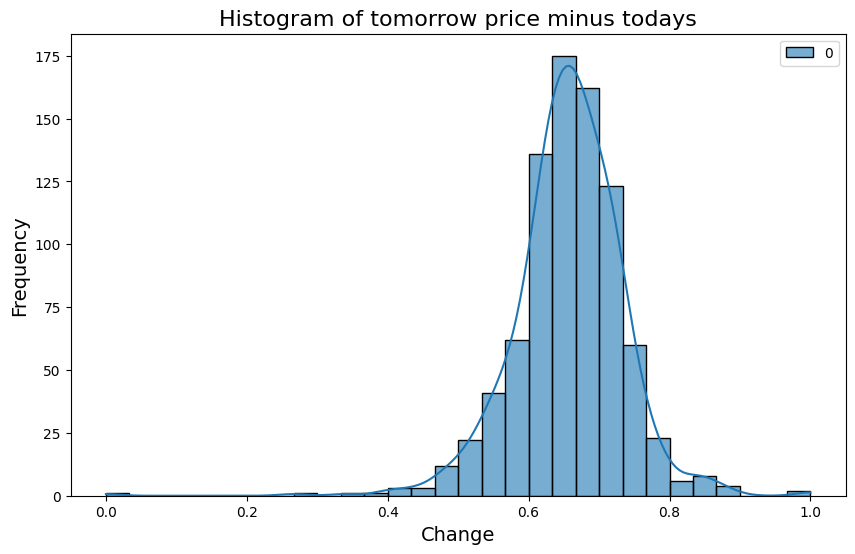

In [104]:
mm = MinMaxScaler()
ss = mm.fit_transform(df_train_all[['pct_change']])

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(ss, bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of tomorrow price minus todays', fontsize=16)
plt.xlabel('Change', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

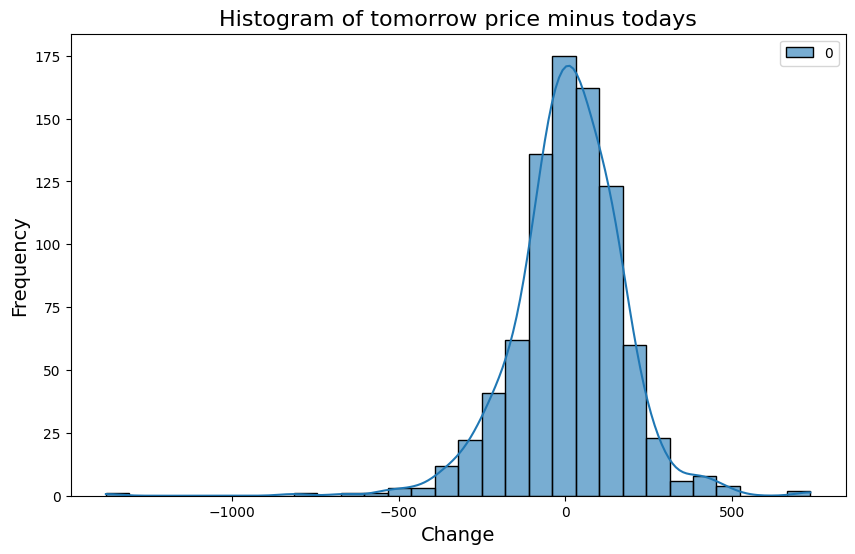

In [105]:
ss_inv = mm.inverse_transform(ss)

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(ss_inv, bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of tomorrow price minus todays', fontsize=16)
plt.xlabel('Change', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

### Back on route

In [73]:
df_train_all.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume,10DMA,30DMA,100DMA,day,month,year,opt_exp,next_close,pct_change
99,2021-06-01,15574.849609,15574.849609,15660.750000,15528.299805,15629.650391,409600,15275.025000,14872.576660,14752.560479,1,6,0,0,15576.200195,1.350586
100,2021-06-02,15576.200195,15576.200195,15597.450195,15459.849609,15520.349609,428600,15329.629980,14913.134993,14766.993477,2,6,0,0,15690.349609,114.149414
101,2021-06-03,15690.349609,15690.349609,15705.099609,15611.000000,15655.549805,410200,15408.059961,14959.599967,14781.901973,3,6,0,0,15670.250000,-20.099609
102,2021-06-04,15670.250000,15670.250000,15733.599609,15622.349609,15712.500000,414200,15457.554980,15001.736621,14797.141973,4,6,0,0,15751.650391,81.400391
103,2021-06-07,15751.650391,15751.650391,15773.450195,15678.099609,15725.099609,394000,15512.950000,15048.746647,14813.284980,7,6,0,0,15740.099609,-11.550781


In [74]:
#df_train_all['price_next'] = df_train_all['Close'].shift(-1)
#df_train_all['prev_close'] = df_train_all['Close'].shift(1)

df_train_all['pct_change_in_a_day'] = df_train_all['Close']/df_train_all['Open']  
df_train_all['opening_gap'] = df_train_all['Open'] - df_train_all['next_close'] 
df_train_all['daily_move'] = df_train_all['High'] - df_train_all['Low']
#df_train_all['daily_move']= df_train_all['daily_move'].shift(1) #previous day daily movement
df_train_all['daily_move_avg'] =  df_train_all['daily_move'].rolling(window=5).mean() #average of last 5 day movement

#df_train_all['price_lag2'] = df_train_all['Adj Close'].shift(2)
#df_train_all['price_lag3'] = df_train_all['Adj Close'].shift(3)
#df_train_all['price_lag4'] = df_train_all['Adj Close'].shift(4)
#df_train_all['price_lag5'] = df_train_all['Adj Close'].shift(5)
#df_train_all.dropna(subset=['price_lag5'], inplace=True)

In [75]:
#df_train_all.drop(['High','Low','Adj Close','daily_move','prev_close'],axis =1, inplace = True) 

In [76]:
df_train_all.tail()

Price,Date,Adj Close,Close,High,Low,Open,Volume,10DMA,30DMA,100DMA,day,month,year,opt_exp,next_close,pct_change,pct_change_in_a_day,opening_gap,daily_move,daily_move_avg
940,2024-10-24,24399.400391,24399.400391,24480.650391,24341.199219,24412.699219,216700,24781.284961,25262.840039,24582.203945,24,10,3,0,24180.800781,-218.599609,0.999455,231.898438,139.451172,283.810156
941,2024-10-25,24180.800781,24180.800781,24440.250000,24073.900391,24418.050781,372600,24702.940039,25222.570052,24591.372949,25,10,3,0,24339.150391,158.349609,0.990284,78.900391,366.349609,293.370313
942,2024-10-28,24339.150391,24339.150391,24492.599609,24134.900391,24251.099609,278600,24624.060156,25188.658398,24615.919453,28,10,3,0,24466.849609,127.699219,1.003631,-215.750000,357.699219,305.169922
943,2024-10-29,24466.849609,24466.849609,24484.500000,24140.849609,24328.849609,332000,24565.010156,25158.095052,24634.384453,29,10,3,0,24340.849609,-126.000000,1.005672,-12.000000,343.650391,286.660156
944,2024-10-30,24340.849609,24340.849609,24498.199219,24307.300781,24371.449219,285200,24501.965039,25122.171680,24649.578945,30,10,3,0,24205.349609,-135.500000,0.998744,166.099609,190.898438,279.609766


In [77]:
# df = df_train_all.copy()

In [78]:
# # Create lists to hold the new columns
# dates = []
# price_type = []
# prices = []

# # Populate the lists using iloc
# for i in range(len(df)):
#     dates.append(df.iloc[i]['Date'])
#     price_type.append('Open')
#     prices.append(df.iloc[i]['Open'])
    
#     dates.append(df.iloc[i]['Date'])
#     price_type.append('Close')
#     prices.append(df.iloc[i]['Close'])

# # Creating a new DataFrame with the desired format
# new_df = pd.DataFrame({
#     'Date': dates,
#     'Type': price_type,
#     'Price': prices
# })

# # Showing the result
# print(new_df.head())


In [79]:
split_date   = '2024-03-31'

df_train = df_train_all[df_train_all['Date']<=  split_date] #keeping 4 years for training 
df_test  = df_train_all[df_train_all['Date']>  split_date] #keeping last year for testing

In [80]:
df_lstm_results  = pd.DataFrame()

In [81]:
df_test.tail()

Price,Date,Adj Close,Close,High,Low,Open,Volume,10DMA,30DMA,100DMA,day,month,year,opt_exp,next_close,pct_change,pct_change_in_a_day,opening_gap,daily_move,daily_move_avg
940,2024-10-24,24399.400391,24399.400391,24480.650391,24341.199219,24412.699219,216700,24781.284961,25262.840039,24582.203945,24,10,3,0,24180.800781,-218.599609,0.999455,231.898438,139.451172,283.810156
941,2024-10-25,24180.800781,24180.800781,24440.250000,24073.900391,24418.050781,372600,24702.940039,25222.570052,24591.372949,25,10,3,0,24339.150391,158.349609,0.990284,78.900391,366.349609,293.370313
942,2024-10-28,24339.150391,24339.150391,24492.599609,24134.900391,24251.099609,278600,24624.060156,25188.658398,24615.919453,28,10,3,0,24466.849609,127.699219,1.003631,-215.750000,357.699219,305.169922
943,2024-10-29,24466.849609,24466.849609,24484.500000,24140.849609,24328.849609,332000,24565.010156,25158.095052,24634.384453,29,10,3,0,24340.849609,-126.000000,1.005672,-12.000000,343.650391,286.660156
944,2024-10-30,24340.849609,24340.849609,24498.199219,24307.300781,24371.449219,285200,24501.965039,25122.171680,24649.578945,30,10,3,0,24205.349609,-135.500000,0.998744,166.099609,190.898438,279.609766


In [82]:
df_train.dropna(subset=['daily_move_avg'], inplace=True)
df_train.columns

/var/folders/ws/v15jk6j56z90j1tz393rgysw0000gn/T/ipykernel_40274/3010578901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.dropna(subset=['daily_move_avg'], inplace=True)


Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', '10DMA',
       '30DMA', '100DMA', 'day', 'month', 'year', 'opt_exp', 'next_close',
       'pct_change', 'pct_change_in_a_day', 'opening_gap', 'daily_move',
       'daily_move_avg'],
      dtype='object', name='Price')

In [83]:
          
df = df_train.copy()
df.drop('Date',axis = 1, inplace = True)
###########################################################################################
###############     Preparing for LSTM              ######################################
#########################################################################################

# Features to be scaled
features_to_scale = ['Close', 'Volume', '10DMA','30DMA', '100DMA', 'next_close',
                      'pct_change_in_a_day', 'opening_gap', 'daily_move','daily_move_avg']

#features_to_scale = ['Open', 'Close','Volume','10DMA','year','day','month','opening_gap','daily_move_avg']
#features_to_scale = ['Open', 'Close','Volume','10DMA','30DMA','100DMA','opening_gap','daily_move_avg']

# Features to be left unscaled (those ending with 'sin' or 'cos')
#features_to_leave = ['opt_exp','month_sin','month_cos','day_sin','day_cos' ]
features_to_leave = ['opt_exp' ]

features = features_to_scale + features_to_leave
#target = 'price_next'
target = 'pct_change'

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, shuffle=False)

#X_train = df[features]
#y_train = df[target]
# Initialize scalers
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale only the selected features
X_train_scaled_part = feature_scaler.fit_transform(X_train[features_to_scale])
X_test_scaled_part = feature_scaler.transform(X_test[features_to_scale])

# Combine scaled features with unscaled features (still as NumPy arrays)
X_train_scaled = np.hstack((X_train_scaled_part, X_train[features_to_leave].values))
X_test_scaled = np.hstack((X_test_scaled_part, X_test[features_to_leave].values))

# Scale target variable
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))


# Reshape data to fit LSTM input shape (num_samples, timesteps, num_features)
timesteps = 1  # You need to define this based on your data and model requirements
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))



In [84]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume,10DMA,30DMA,100DMA,day,month,year,opt_exp,next_close,pct_change,pct_change_in_a_day,opening_gap,daily_move,daily_move_avg
103,15751.650391,15751.650391,15773.450195,15678.099609,15725.099609,394000,15512.950000,15048.746647,14813.284980,7,6,0,0,15740.099609,-11.550781,1.001688,-15.000000,95.350586,114.150195
104,15740.099609,15740.099609,15778.799805,15680.000000,15773.900391,378200,15566.114941,15090.583301,14827.213477,8,6,0,0,15635.349609,-104.750000,0.997857,138.550781,98.799805,107.420117
105,15635.349609,15635.349609,15800.450195,15566.900391,15766.299805,457900,15599.504883,15123.326628,14838.719473,9,6,0,0,15737.750000,102.400391,0.991694,28.549805,233.549805,126.609961
106,15737.750000,15737.750000,15751.250000,15648.500000,15692.099609,298300,15639.494922,15152.433301,14850.462471,10,6,0,0,15799.349609,61.599609,1.002909,-107.250000,102.750000,128.340039
107,15799.349609,15799.349609,15835.549805,15749.799805,15796.450195,363000,15675.864844,15182.581608,14862.807471,11,6,0,0,15811.849609,12.500000,1.000184,-15.399414,85.750000,123.240039


In [85]:

# Build your LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(1024, return_sequences=True, input_shape=(timesteps, X_train_reshaped.shape[2]))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(1024, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(0.2))

model.add(Dense(1))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model with RMSLE as the loss function
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae','mse'])

# Train the model
history = model.fit(X_train_reshaped, 
                    y_train_scaled, 
                    epochs=100, 
                    validation_data=(X_test_reshaped, y_test_scaled), 
                    batch_size=32,
                    callbacks=[early_stopping])


Epoch 1/100


/opt/anaconda3/envs/Conda_310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.3501 - mae: 0.5762 - mse: 0.3501 - val_loss: 0.0273 - val_mae: 0.1387 - val_mse: 0.0273
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0685 - mae: 0.2216 - mse: 0.0685 - val_loss: 0.2338 - val_mae: 0.4394 - val_mse: 0.2338
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0311 - mae: 0.1419 - mse: 0.0311 - val_loss: 0.1122 - val_mae: 0.2882 - val_mse: 0.1122
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0260 - mae: 0.1311 - mse: 0.0260 - val_loss: 0.0777 - val_mae: 0.2319 - val_mse: 0.0777
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0258 - mae: 0.1277 - mse: 0.0258 - val_loss: 0.0624 - val_mae: 0.2039 - val_mse: 0.0624
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0239 - mae: 0.1215 - mse: 0.0239 - val_loss: 0.0494 - val_mae: 0.1772 - val_mse: 0.0494
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0209 - mae: 0.1110 - mse: 0.0209 - val_loss: 0.025

In [86]:

##############################################################################################
#########################          Make Predictions              #############################
##############################################################################################


# Predictions
lstm_predictions = model.predict(X_test_reshaped)

# Ensure both predictions and actual values are of type float64
y_test_scaled = y_test_scaled.reshape(-1, 1).astype('float64')
lstm_predictions_scaled = lstm_predictions.astype('float64')

# Calculate RMSLE
lstm_rmsle_val = call_rmsle(y_test_scaled, lstm_predictions_scaled)

y_test_actual = target_scaler.inverse_transform(y_test_scaled).astype('float64')
lstm_predictions_actual = target_scaler.inverse_transform(lstm_predictions_scaled).astype('float64')
lstm_rmsle_val_actual = call_rmsle(y_test_actual, lstm_predictions_actual)
print("RSMLE we got is ",lstm_rmsle_val_actual)

#

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
RSMLE we got is  tf.Tensor(0.5418721114547006, shape=(), dtype=float64)


## Applying model on Test Data

In [87]:
#############################################################################################
#########################             Applying model on test data       ######################
##############################################################################################

del df
df   = df_test.copy()

df.drop('Date',axis = 1, inplace = True)
###########################################################################################
###############     Preparing for LSTM              ######################################
#########################################################################################


# Scale only the selected features
X_test_scaled_part = feature_scaler.transform(df[features_to_scale])

# Combine scaled features with unscaled features (still as NumPy arrays)
X_test_scaled = np.hstack((X_test_scaled_part, df[features_to_leave].values))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))

# Predictions
lstm_predictions = model.predict(X_test_reshaped)
lstm_predictions_scaled = lstm_predictions.astype('float64')

lstm_predictions_actual = target_scaler.inverse_transform(lstm_predictions_scaled).astype('float64')

# Add predictions to the dataframe
df_test['pct_change_predicted'] = lstm_predictions_actual



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/var/folders/ws/v15jk6j56z90j1tz393rgysw0000gn/T/ipykernel_40274/2593838429.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pct_change_predicted'] = lstm_predictions_actual


In [92]:
#df_test['predicted_price_tomorrow'] = df_test['pct_change_predicted']*df_test['Close']
#df_test['predicted_price_today'] = df_test['predicted_price_tomorrow'].shift(1)
df_test['predicted_close'] = df_test['Close'] + df_test['pct_change_predicted']

/var/folders/ws/v15jk6j56z90j1tz393rgysw0000gn/T/ipykernel_40274/1327544456.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_close'] = df_test['Close'] + df_test['pct_change_predicted']


In [93]:
df_test.head(100)

Price,Date,Adj Close,Close,High,Low,Open,Volume,10DMA,30DMA,100DMA,day,month,year,opt_exp,next_close,pct_change,pct_change_in_a_day,opening_gap,daily_move,daily_move_avg,pct_change_predicted,predicted_close
800,2024-04-01,22462.000000,22462.000000,22529.949219,22427.750000,22455.000000,0,22076.154687,22155.089909,21332.528438,1,4,3,0,22453.300781,-8.699219,1.000312,1.699219,102.199219,203.679297,26.963853,22488.963853
801,2024-04-02,22453.300781,22453.300781,22497.599609,22388.150391,22458.800781,289500,22119.149805,22173.174935,21365.728945,2,4,3,0,22434.650391,-18.650391,0.999755,24.150391,109.449219,166.089453,2.784116,22456.084897
802,2024-04-03,22434.650391,22434.650391,22521.099609,22346.500000,22385.699219,309600,22157.044922,22186.306641,21397.769453,3,4,3,0,22514.650391,80.000000,1.002187,-128.951172,174.599609,175.879687,110.985592,22545.635983
803,2024-04-04,22514.650391,22514.650391,22619.000000,22303.800781,22592.099609,401000,22226.765039,22199.386654,21428.798457,4,4,3,0,22513.699219,-0.951172,0.996572,78.400391,315.199219,210.769531,9.051103,22523.701493
804,2024-04-05,22513.699219,22513.699219,22537.599609,22427.599609,22486.400391,242200,22294.225000,22209.944987,21459.868457,5,4,3,0,22666.300781,152.601562,1.001214,-179.900391,110.000000,162.289453,182.940088,22696.639306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,2024-08-21,24770.199219,24770.199219,24787.949219,24654.500000,24680.550781,257100,24399.459961,24505.528255,23341.757969,21,8,3,0,24811.500000,41.300781,1.003632,-130.949219,133.449219,166.520703,108.351603,24878.550822
896,2024-08-22,24811.500000,24811.500000,24867.349609,24784.449219,24863.400391,220300,24450.859961,24518.138281,23368.905469,22,8,3,0,24823.150391,11.650391,0.997913,40.250000,82.900391,163.740625,53.107651,24864.607651
897,2024-08-23,24823.150391,24823.150391,24858.400391,24771.650391,24845.400391,206800,24521.475000,24534.761654,23397.089980,23,8,3,0,25010.599609,187.449219,0.999104,-165.199219,86.750000,109.210547,242.178261,25065.328651
898,2024-08-26,25010.599609,25010.599609,25043.800781,24874.699219,24906.099609,210300,24585.784961,24557.916667,23425.959473,26,8,3,0,25017.750000,7.150391,1.004196,-111.650391,169.101562,119.860547,78.384166,25088.983776


In [94]:
df_test.dropna(subset=['predicted_close'], inplace=True)

/var/folders/ws/v15jk6j56z90j1tz393rgysw0000gn/T/ipykernel_40274/3938800536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.dropna(subset=['predicted_close'], inplace=True)


In [108]:
df_test['prediction_diff'] =  df_test['predicted_close']-df_test['next_close']
df_test['pct_prediction_diff'] = df_test['prediction_diff']/df_test['next_close']*100

df_test[['next_close','predicted_close','prediction_diff','pct_prediction_diff']]


/var/folders/ws/v15jk6j56z90j1tz393rgysw0000gn/T/ipykernel_40274/898375700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction_diff'] =  df_test['predicted_close']-df_test['next_close']
/var/folders/ws/v15jk6j56z90j1tz393rgysw0000gn/T/ipykernel_40274/898375700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pct_prediction_diff'] = df_test['prediction_diff']/df_test['next_close']*100


Price,next_close,predicted_close,prediction_diff,pct_prediction_diff
800,22453.300781,22488.963853,35.663072,0.158832
801,22434.650391,22456.084897,21.434506,0.095542
802,22514.650391,22545.635983,30.985592,0.137624
803,22513.699219,22523.701493,10.002275,0.044428
804,22666.300781,22696.639306,30.338525,0.133849
...,...,...,...,...
940,24180.800781,24210.893924,30.093143,0.124451
941,24339.150391,24351.790506,12.640115,0.051933
942,24466.849609,24538.672217,71.822607,0.293551
943,24340.849609,24401.451615,60.602006,0.248972


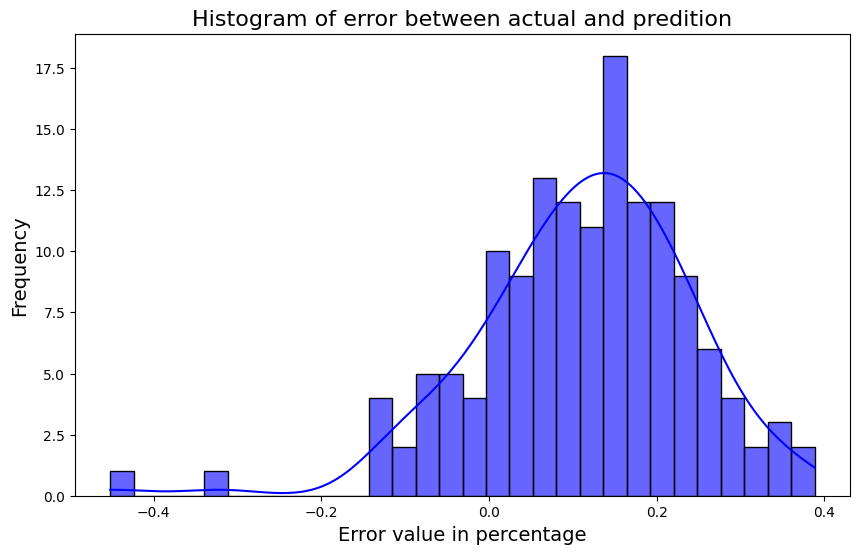

In [109]:
# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_test['pct_prediction_diff'], bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of error between actual and predition', fontsize=16)
plt.xlabel('Error value in percentage', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

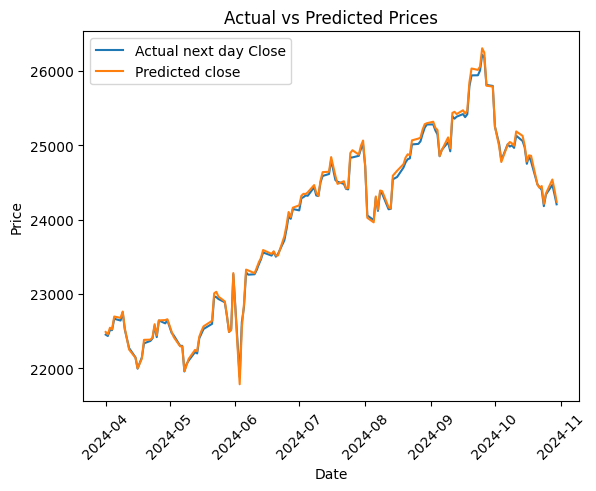

In [96]:
import matplotlib.pyplot as plt

# Plot the actual prices ('Close') and the predicted prices ('predicted_close')
plt.plot(df_test['Date'], df_test['next_close'], label='Actual next day Close')
plt.plot(df_test['Date'], df_test['predicted_close'], label='Predicted close')

# Add a title, labels, and legend
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()